In [368]:
import pandas as pd
import os
import matplotlib
import itchat
import math
import operator
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
user_df=pd.read_csv('./data/t_user.csv')
order_df=pd.read_csv('./data/t_order.csv')
loan_df=pd.read_csv('./data/t_loan.csv')
loan_sum_df=pd.read_csv('./data/t_loan_sum.csv')
click_df=pd.read_csv('./data/t_click.csv')

In [288]:
loan_dt=datetime.datetime.strptime('2016-11-01 00:00:00','%Y-%m-%d %H:%M:%S')
loan_df['loan_gap']=loan_df['loan_time'].apply(lambda x: loan_dt- (datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')))
loan_df['loan_gap']=loan_df['loan_gap'].apply(lambda x: x.days)

### 划分样本集

In [293]:
train_time='2016-11-01'
span_time='2016-09-01'
train_order_df=order_df[order_df['buy_time']<train_time]
train_click_df=click_df[click_df['click_time']<train_time]
train_loan_df=loan_df[loan_df['loan_time']<train_time]
span_order_df=order_df[order_df['buy_time']>=span_time]
span_click_df=click_df[click_df['click_time']>=span_time]
span_loan_df=loan_df[loan_df['loan_time']>=span_time]

### 获取用户订单信息

In [259]:
def get_order_feature(df):
    order_group=df.groupby('uid')
    order_feature=[]
    for uid,group in order_group:
        group=group.reset_index()
        order_feature_dict={}
        order_feature_dict['uid']=uid
        order_feature_dict['total_order']=len(group)
        order_feature_dict['unique_cate_count']=len(group['cate_id'].unique())
        order_feature_dict['max_qty']=group['qty'].max()
        order_feature_dict['max_price']=group['price'].max()
        order_feature_dict['max_discount']=group['discount'].max()
        total_price=0
        for i in range(len(group)):
            total_price+=group.loc[i,'qty']*group.loc[i,'price']
        order_feature_dict['total_price']=total_price
        order_feature.append(order_feature_dict)
    order_feature_df=pd.DataFrame(order_feature)
    return order_feature_df

In [175]:
#order_feature_df.to_csv('./feature/order_feature.csv',index=False)

### 提取历史借贷行为 

In [310]:
def get_loan_feature(df):
    loan_group=df.groupby('uid')
    loan_feature=[]
    cnt=0
    for uid,group in loan_group:
        cnt+=1
        if cnt%10000==0:
            print "count total user:","cnt"
        loan_feature_dict={}
        group=group.reset_index()
        loan_feature_dict['uid']=uid
        loan_feature_dict['loan_count_3m']=len(group)
        loan_feature_dict['loan_amout__3m']=group['loan_amount'].sum()
        loan_gap=list(group['loan_gap'])
        for day_diff in [7,14,21,28,35,42,49,56,63,70,90]:
            loan_feature_dict['last_'+str(day_diff)+'_day_loan_count']=len([i for i in loan_gap if i <=day_diff])
            loan_feature_dict['last_'+str(day_diff)+'_day_loan_amount']=sum([group.loc[loan_gap.index(i),'loan_amount'] for i in loan_gap if i<=day_diff])
        loan_feature.append(loan_feature_dict)
    return pd.DataFrame(loan_feature)

### merge feature

#### 训练集特征

In [ ]:
train_order_feature=get_order_feature(train_order_df)
train_loan_feature=get_loan_feature(train_loan_df)
train_feature=pd.merge(user_df,train_order_feature,on='uid',how='left')
train_feature=pd.merge(train_feature,train_loan_feature,on='uid',how='left')
train_label=pd.merge(user_df,loan_sum_df,on='uid',how='left')
train_label.fillna(0,inplace=True)
train_label=train_label[['uid','loan_sum']]
train_data=pd.merge(train_label,train_feature,on='uid',how='left')
train_data.drop(['active_date'],axis=1,inplace=True)

In [ ]:
span_order_feature=get_order_feature(span_order_df)
span_loan_feature=get_loan_feature(span_loan_df)
span_feature=pd.merge(user_df,span_order_feature,on='uid',how='left')
span_feature=pd.merge(span_feature,span_loan_feature,on='uid',how='left')
span_feature.drop(['active_date'],axis=1,inplace=True)
span_feature.shape
span_data=span_feature

In [354]:
used_features=list(train_data.columns)
used_features.remove('uid')
used_features.remove('loan_sum')
train_df=train_data[used_features]
train_target=train_data.loan_sum
span_df=span_data[used_features]

In [379]:
dtrain=xgb.DMatrix(train_df,label=train_target)
dspan=xgb.DMatrix(span_df)
our_params={'eta':0.1,'seed':0,'subsample':0.8,'colsample_bytree':0.8,'objective':'reg:linear','max_depth':4,'min_child_weight':1}
model=xgb.train(our_params,dtrain,400)
train_predict=model.predict(dtrain)
print calc_RMSE(list(train_target),list(train_predict))
span_predict=model.predict(dspan)
span_result=pd.DataFrame()
span_result['uid']=span_data['uid']
span_result['predict']=span_predict

1.72452758135


In [393]:
span_result.to_csv('./result.csv',index=False)

In [319]:
def calc_RMSE(true_y,predict_y):
    n=len(true_y)
    result=0
    for i in range(n):
        result+=pow((true_y[i]-predict_y[i]),2)
    return math.sqrt(1.0*result/n)

In [365]:
def ceate_feature_map(features):  
    outfile = open('xgb.fmap', 'w')  
    i = 0  
    for feat in features:  
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))  
        i = i + 1  
    outfile.close() 

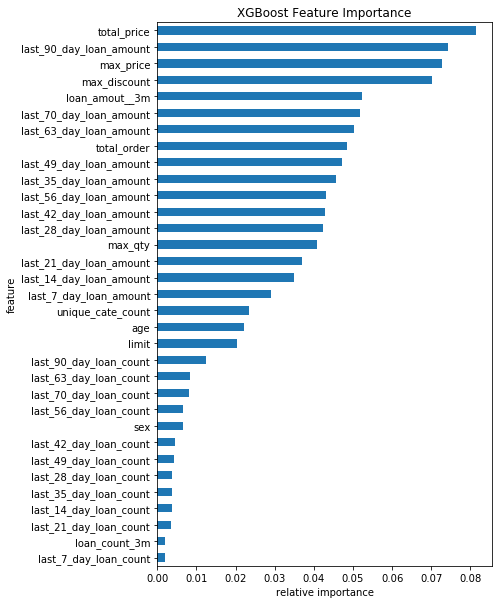

In [399]:
ceate_feature_map(used_features)  

importance = model.get_fscore(fmap='xgb.fmap')  
importance = sorted(importance.items(), key=operator.itemgetter(1))  

feature_importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])  
feature_importance_df['fscore'] = feature_importance_df['fscore'] / feature_importance_df['fscore'].sum()
plt.figure()
feature_importance_df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))  
plt.title('XGBoost Feature Importance')  
plt.xlabel('relative importance')  
plt.show()